In [1]:
%load_ext autoreload
%autoreload 2

# A pronounced loss of tree crown foliation results in multi-year growth reduction

We train model to predict the growth of trees during a given period of 4-6 years based on the following features:

| feature            | description                                  | level |
|--------------------|----------------------------------------------|-------|
| diameter_end       | Diameter at the end of the period            | tree  |
| defoliation_max    | Maximum defoliation of the growth period     | tree  |
| defoliation_min    | Minimum defoliation of the growth period     | tree  |
| defoliation_mean   | Mean defoliation of the growth period        | tree  |
| defoliation_median | Median defoliation of the growth period      | tree  |
| social_class_min   | Minimum social class of the growth period    | tree  |
| plot_latitude      | Latitude of the plot                         | plot  |
| plot_longitude     | Longitude of the plot                        | plot  |
| plot_slope         | Slope of the plot                            | plot  |
| plot_orientation   | Orientation of the plot                      | plot  |
| plot_altitude      | Altitude of the plot                         | plot  |
| dep_ph             | Deposition pH                                | plot  |
| dep_cond           | Deposition conductivity                      | plot  |
| dep_k              | Deposition potassium (K)                     | plot  |
| dep_ca             | Deposition calcium (Ca)                      | plot  |
| dep_mg             | Deposition magnesium (Mg)                    | plot  |
| dep_na             | Deposition sodium (Na)                       | plot  |
| dep_n_nh4          | Deposition ammonium (NH4)                    | plot  |
| dep_cl             | Deposition chloride (Cl)                     | plot  |
| dep_n_no3          | Deposition nitrate (NO3)                     | plot  |
| dep_s_so4          | Deposition sulfate (SO4)                     | plot  |
| dep_alk            | Deposition alkalinity                        | plot  |
| dep_n_tot          | Deposition total nitrogen (N)                | plot  |
| dep_doc            | Deposition dissolved organic carbon (DOC)    | plot  |
| dep_al             | Deposition aluminium (Al)                    | plot  |
| dep_mn             | Deposition manganese (Mn)                    | plot  |
| dep_fe             | Deposition iron (Fe)                         | plot  |
| dep_p_po4          | Deposition phosphate (PO4)                   | plot  |
| dep_cu             | Deposition copper (Cu)                       | plot  |
| dep_zn             | Deposition zinc (Zn)                         | plot  |
| dep_hg             | Deposition mercury (Hg)                      | plot  |
| dep_pb             | Deposition lead (Pb)                         | plot  |
| dep_co             | Deposition cobalt (Co)                       | plot  |
| dep_ni             | Deposition nickel (Ni)                       | plot  |
| dep_cd             | Deposition cadmium (Cd)                      | plot  |
| dep_s_tot          | Deposition total sulfur (S)                  | plot  |
| dep_c_tot          | Deposition total carbon (C)                  | plot  |
| dep_n_org          | Deposition organic nitrogen (N)              | plot  |
| dep_p_tot          | Deposition total phosphorus (P)              | plot  |
| dep_cr             | Deposition chromium (Cr)                     | plot  |
| dep_n_no2          | Deposition nitrite (NO2)                     | plot  |
| ss_ph              | Soil solution pH                             | plot  |
| ss_cond            | Soil solution conductivity                   | plot  |
| ss_k               | Soil solution potassium (K)                  | plot  |
| ss_ca              | Soil solution calcium (Ca)                   | plot  |
| ss_mg              | Soil solution magnesium (Mg)                 | plot  |
| ss_n_no3           | Soil solution nitrate (NO3)                  | plot  |
| ss_s_so4           | Soil solution sulfate (SO4)                  | plot  |
| ss_alk             | Soil solution alkalinity                     | plot  |
| ss_al              | Soil solution aluminium (Al)                 | plot  |
| ss_doc             | Soil solution dissolved organic carbon (DOC) | plot  |
| ss_na              | Soil solution sodium (Na)                    | plot  |
| ss_n_nh4           | Soil solution ammonium (NH4)                 | plot  |
| ss_cl              | Soil solution chloride (Cl)                  | plot  |
| ss_n_tot           | Soil solution total nitrogen (N)             | plot  |
| ss_fe              | Soil solution iron (Fe)                      | plot  |
| ss_mn              | Soil solution manganese (Mn)                 | plot  |
| ss_al_labile       | Soil solution labile aluminium (Al)          | plot  |
| ss_p               | Soil solution phosphorus (P)                 | plot  |
| ss_cr              | Soil solution chromium (Cr)                  | plot  |
| ss_ni              | Soil solution nickel (Ni)                    | plot  |
| ss_zn              | Soil solution zinc (Zn)                      | plot  |
| ss_cu              | Soil solution copper (Cu)                    | plot  |
| ss_pb              | Soil solution lead (Pb)                      | plot  |
| ss_cd              | Soil solution cadmium (Cd)                   | plot  |
| ss_si              | Soil solution silicon (Si)                   | plot  |
| soph_avg_sdi       | Average species diversity index              | plot  |
| soph_avg_age       | Average age of the trees                     | plot  |
| soph_avg_temp      | Average temperature                          | plot  |
| soph_avg_precip    | Average precipitation                        | plot  |

Here we import key libraries used in the notebook (run `uv sync` and select the corresponding kernel if some of them are missing).

In [2]:
# Main libraries
import shap
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# We will use Polars for data manipulation
import polars as pl

# Casting types from time to time to have a better autocompletion
from typing import cast

from models import (
    train_and_explain,
    optimize_hyperparameters,
    ExperimentResults,
    Species,
    r2_score,
)

from functools import partial

/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We then optimize hyperparameters and train models for every species. We may also select here the type of grouping used by the K-fold validation.

In [3]:
# Predict the 95th percentile of the distribution
# objective = "quantile"
# alpha = 0.50

# Predict the mean of the distribution
objective = "regression"
alpha = None

group_col = "tree_id"
all_species: list[Species] = ["spruce", "pine", "beech", "oak"]
all_results: dict[str, ExperimentResults] = {}

r2_score = partial(r2_score, objective=objective, alpha=alpha)

for species in all_species:
    best_params, best_value = optimize_hyperparameters(
        species, group_col=group_col, objective=objective, alpha=alpha
    )

    all_results[species] = train_and_explain(species, best_params, group_col=group_col)

[I 2025-02-21 16:13:53,743] A new study created in memory with name: no-name-51e7b23e-9806-47c0-be80-e758abe81a10


KS Statistic: 0.019460609288104724
P-value: 3.5e-05


/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/res

Best parameters found: {'num_leaves': 122, 'max_depth': 10, 'min_data_in_leaf': 75, 'lambda_l1': 0.6744000295775244, 'lambda_l2': 0.01611966693877944, 'min_gain_split': 0.0011745678063418419, 'feature_fraction': 0.5152479282935429, 'bagging_fraction': 0.8003588042402517, 'bagging_freq': 4}
with test R2: 0.48554617881014045
Training model for spruce
KS Statistic: 0.019460609288104724
P-value: 3.5e-05
[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=0.6744000295775244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6744000295775244
[LightGBM] [Warning] lambda_l2 is set=0.01611966693877944, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01611966693877944
[LightGBM] [Warning] bagging_fraction is set=0.8003588042402517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8003588042402517
[LightGBM] [Warnin

/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/res

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/res

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=0.6744000295775244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6744000295775244
[LightGBM] [Warning] lambda_l2 is set=0.01611966693877944, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01611966693877944
[LightGBM] [Warning] bagging_fraction is set=0.8003588042402517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8003588042402517
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75

/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/res

[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=0.6744000295775244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6744000295775244
[LightGBM] [Warning] lambda_l2 is set=0.01611966693877944, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01611966693877944
[LightGBM] [Warning] bagging_fraction is set=0.8003588042402517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8003588042402517
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] feature_fraction is set=0.5152479282935429, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5152479282935429
[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current valu

/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/res

Best parameters found: {'num_leaves': 107, 'max_depth': 13, 'min_data_in_leaf': 28, 'lambda_l1': 1.165987652877087, 'lambda_l2': 1.2326391959125852e-05, 'min_gain_split': 0.02283077336889378, 'feature_fraction': 0.7718070077691758, 'bagging_fraction': 0.7231431042140296, 'bagging_freq': 6}
with test R2: 0.44448514968561686
Training model for pine
KS Statistic: 0.023578668829044414
P-value: 6.4e-05
[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=1.165987652877087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.165987652877087
[LightGBM] [Warning] lambda_l2 is set=1.2326391959125852e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2326391959125852e-05
[LightGBM] [Warning] bagging_fraction is set=0.7231431042140296, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7231431042140296
[LightGBM] [Warn

/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/res

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=1.165987652877087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.165987652877087
[LightGBM] [Warning] lambda_l2 is set=1.2326391959125852e-05, reg_lambda=0.0 will be ignored. Current valu

/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/res

[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=1.165987652877087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.165987652877087
[LightGBM] [Warning] lambda_l2 is set=1.2326391959125852e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2326391959125852e-05
[LightGBM] [Warning] bagging_fraction is set=0.7231431042140296, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7231431042140296
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.7718070077691758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7718070077691758
[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current 

/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/res

Best parameters found: {'num_leaves': 49, 'max_depth': 14, 'min_data_in_leaf': 28, 'lambda_l1': 5.505855100121709e-05, 'lambda_l2': 0.005317180224519581, 'min_gain_split': 0.06154662806845366, 'feature_fraction': 0.4417362109525268, 'bagging_fraction': 0.6288681218110793, 'bagging_freq': 3}
with test R2: 0.4600407758259067
Training model for beech
KS Statistic: 0.026593916105136194
P-value: 8.6e-05
[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=5.505855100121709e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.505855100121709e-05
[LightGBM] [Warning] lambda_l2 is set=0.005317180224519581, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005317180224519581
[LightGBM] [Warning] bagging_fraction is set=0.6288681218110793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6288681218110793
[LightGBM] 

/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=5.505855100121709e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.505855100121709e-05
[LightGBM] [Warning] lambda_l2 is set=0.005317180224519581, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005317180224519581
[LightGBM] [Warning] bagging_fraction is set=0.6288681218110793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6288681218110793
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.4417362109525268, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4417362109525268
[LightGBM] [Warning] No further splits with positive gain, bes

/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/res

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=5.505855100121709e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.505855100121709e-05
[LightGBM] [Warning] lambda_l2 is set=0.005317180224519581, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005317180224519581
[LightGBM] [Warning] bagging_fraction is set=0.6288681218110793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6288681218110793
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.4417362109525268, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4417362109525268
[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightG

/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/res

[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=5.505855100121709e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.505855100121709e-05
[LightGBM] [Warning] lambda_l2 is set=0.005317180224519581, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005317180224519581
[LightGBM] [Warning] bagging_fraction is set=0.6288681218110793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6288681218110793
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.4417362109525268, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4417362109525268
[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Curr

/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/res

Best parameters found: {'num_leaves': 35, 'max_depth': 13, 'min_data_in_leaf': 59, 'lambda_l1': 3.768675431978249e-07, 'lambda_l2': 0.001684950505674037, 'min_gain_split': 0.05642309167826938, 'feature_fraction': 0.8533387461515822, 'bagging_fraction': 0.7624599817863734, 'bagging_freq': 4}
with test R2: 0.37194345880344837
Training model for oak
KS Statistic: 0.031178232395600802
P-value: 0.013
[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=3.768675431978249e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.768675431978249e-07
[LightGBM] [Warning] lambda_l2 is set=0.001684950505674037, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001684950505674037
[LightGBM] [Warning] bagging_fraction is set=0.7624599817863734, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7624599817863734
[LightGBM] [Wa

/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/res

[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=3.768675431978249e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.768675431978249e-07
[LightGBM] [Warning] lambda_l2 is set=0.001684950505674037, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001684950505674037
[LightGBM] [Warning] bagging_fraction is set=0.7624599817863734, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7624599817863734
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] feature_fraction is set=0.8533387461515822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8533387461515822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/res

## Evaluate model performance for each species

Here we compute the mean and standard deviation of the $R^2$ (coefficient of determination) for all species and folds.

In [4]:
for species, results in all_results.items():
    perf = pl.from_dicts(results.performances).select(
        pl.first().cum_count().alias("fold"), "test_r2", "train_r2"
    )

    r2_mean = perf.select("test_r2").mean().item()
    r2_std = perf.select("test_r2").std().item()

    print(f"Results for {species}")
    print(perf.select(pl.selectors.contains("r2")).describe(percentiles=None))

Results for spruce
shape: (6, 3)
┌────────────┬──────────┬──────────┐
│ statistic  ┆ test_r2  ┆ train_r2 │
│ ---        ┆ ---      ┆ ---      │
│ str        ┆ f64      ┆ f64      │
╞════════════╪══════════╪══════════╡
│ count      ┆ 5.0      ┆ 5.0      │
│ null_count ┆ 0.0      ┆ 0.0      │
│ mean       ┆ 0.484981 ┆ 0.555556 │
│ std        ┆ 0.017187 ┆ 0.004667 │
│ min        ┆ 0.463741 ┆ 0.549627 │
│ max        ┆ 0.503589 ┆ 0.560872 │
└────────────┴──────────┴──────────┘
Results for pine
shape: (6, 3)
┌────────────┬──────────┬──────────┐
│ statistic  ┆ test_r2  ┆ train_r2 │
│ ---        ┆ ---      ┆ ---      │
│ str        ┆ f64      ┆ f64      │
╞════════════╪══════════╪══════════╡
│ count      ┆ 5.0      ┆ 5.0      │
│ null_count ┆ 0.0      ┆ 0.0      │
│ mean       ┆ 0.438336 ┆ 0.575319 │
│ std        ┆ 0.029895 ┆ 0.006387 │
│ min        ┆ 0.40876  ┆ 0.564085 │
│ max        ┆ 0.486758 ┆ 0.579292 │
└────────────┴──────────┴──────────┘
Results for beech
shape: (6, 3)
┌────────────┬──

In [5]:
# Save the results of defoliation predictions
from config import TARGET

if TARGET == "defoliation_mean":
    print("Saving defoliation predictions")
    for species, results in all_results.items():
        for fold in range(results.num_folds):
            assert len(results.y_true) == len(results.y_pred[fold])
            np.save(
                f"./data/predictions/{TARGET}-{species}-{fold}.npy",
                results.y_pred[fold].to_numpy(),
                allow_pickle=False,
            )

## Plot/period-wise R2 test scores

Here we compute plot/period-wise R2 test scores to ensure that models do not merely predict the plot average.

Decision plot for spruce fold 0 with R2=0.654


/var/folders/8w/bgtq_bb95_bgd7nxmt9xj04h0000gn/T/ipykernel_64797/2404336199.py:28: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()


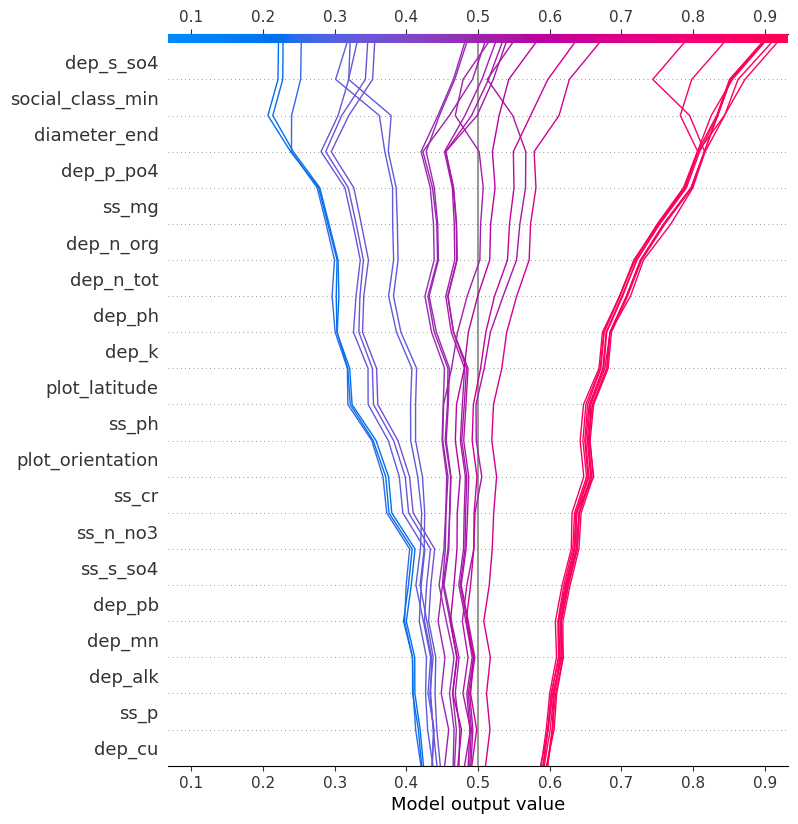

Decision plot for spruce fold 1 with R2=0.647


/var/folders/8w/bgtq_bb95_bgd7nxmt9xj04h0000gn/T/ipykernel_64797/2404336199.py:28: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()


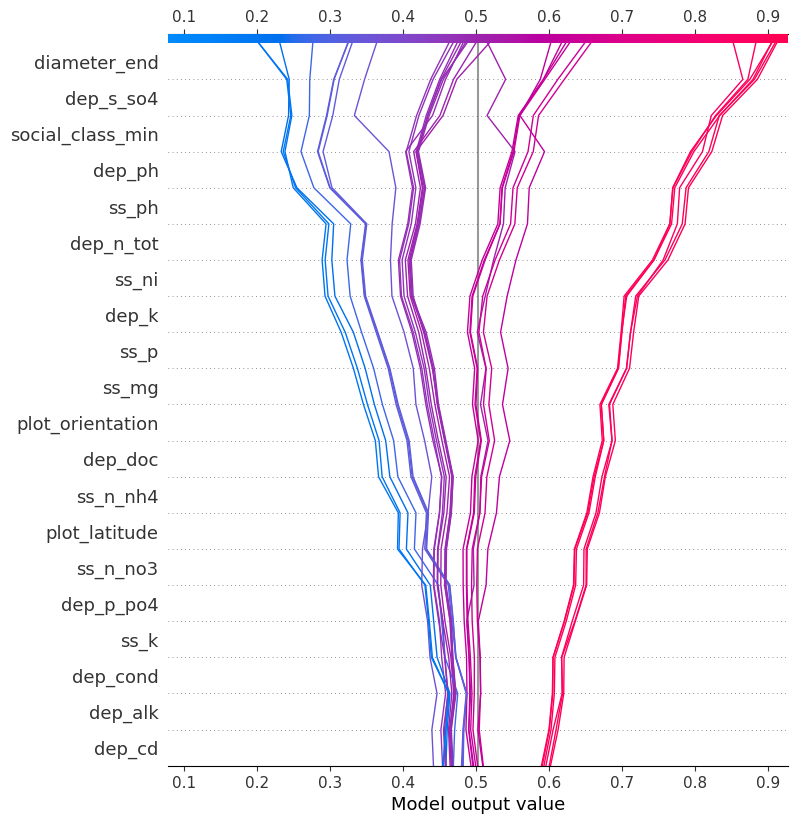

Decision plot for spruce fold 3 with R2=0.536


/var/folders/8w/bgtq_bb95_bgd7nxmt9xj04h0000gn/T/ipykernel_64797/2404336199.py:28: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()
/var/folders/8w/bgtq_bb95_bgd7nxmt9xj04h0000gn/T/ipykernel_64797/2404336199.py:28: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()


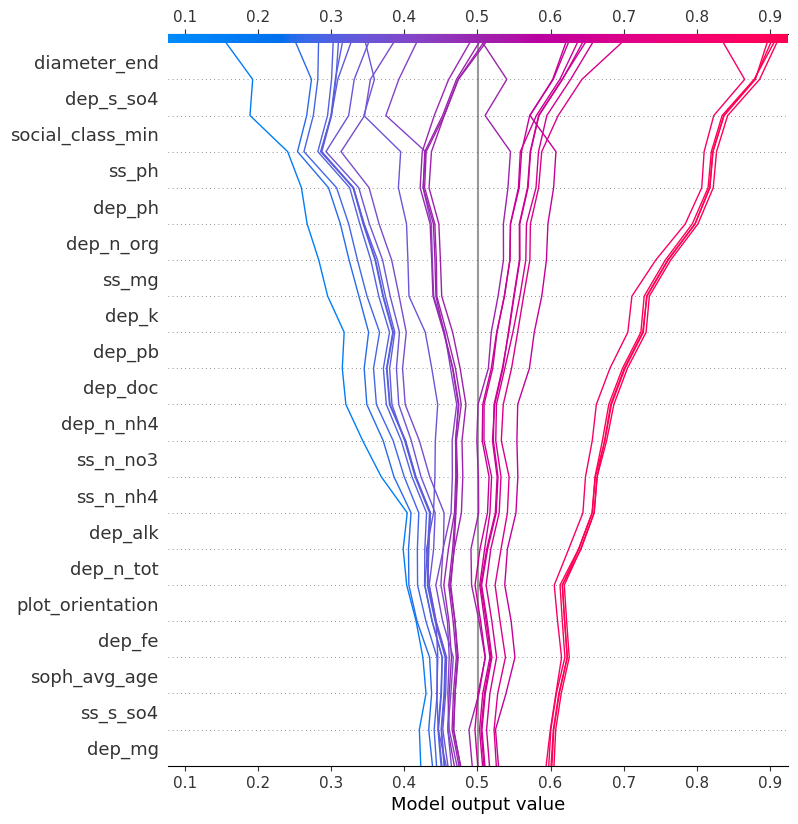

/var/folders/8w/bgtq_bb95_bgd7nxmt9xj04h0000gn/T/ipykernel_64797/2404336199.py:28: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()


Decision plot for pine fold 0 with R2=0.554


/var/folders/8w/bgtq_bb95_bgd7nxmt9xj04h0000gn/T/ipykernel_64797/2404336199.py:28: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()


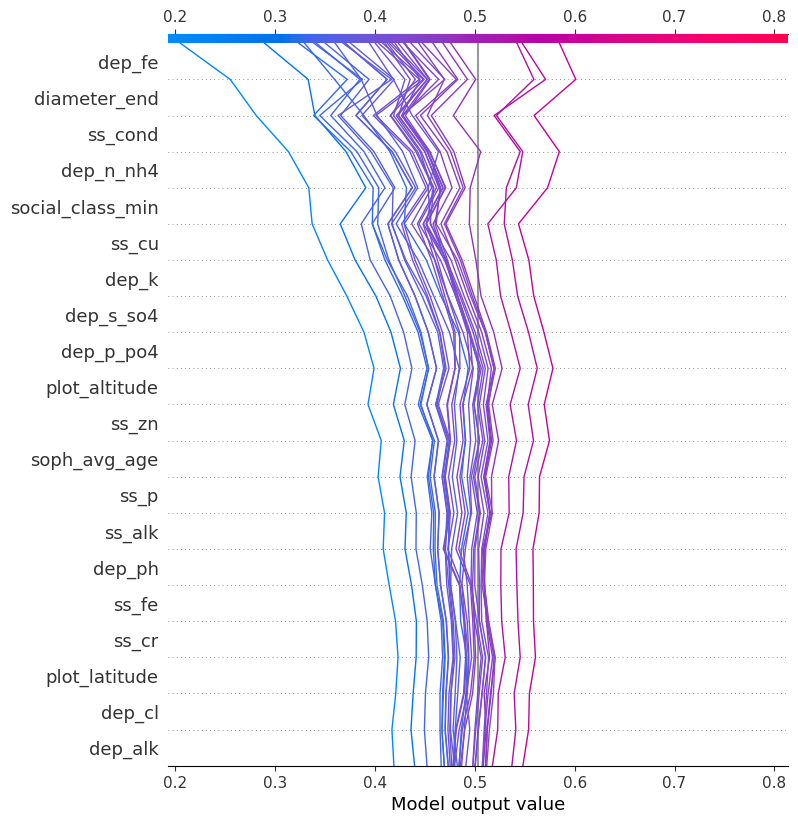

/var/folders/8w/bgtq_bb95_bgd7nxmt9xj04h0000gn/T/ipykernel_64797/2404336199.py:28: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()
/var/folders/8w/bgtq_bb95_bgd7nxmt9xj04h0000gn/T/ipykernel_64797/2404336199.py:28: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()


Decision plot for beech fold 0 with R2=0.696


/var/folders/8w/bgtq_bb95_bgd7nxmt9xj04h0000gn/T/ipykernel_64797/2404336199.py:28: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()
/var/folders/8w/bgtq_bb95_bgd7nxmt9xj04h0000gn/T/ipykernel_64797/2404336199.py:28: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()
/var/folders/8w/bgtq_bb95_bgd7nxmt9xj04h0000gn/T/ipykernel_64797/2404336199.py:28: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()


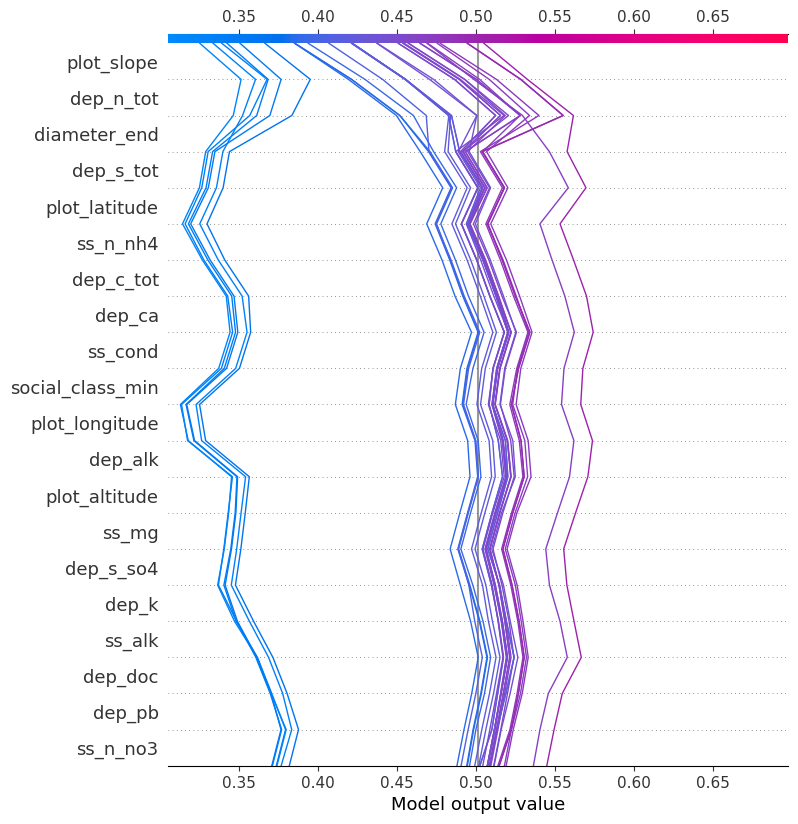

/var/folders/8w/bgtq_bb95_bgd7nxmt9xj04h0000gn/T/ipykernel_64797/2404336199.py:28: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()


Decision plot for beech fold 1 with R2=0.658


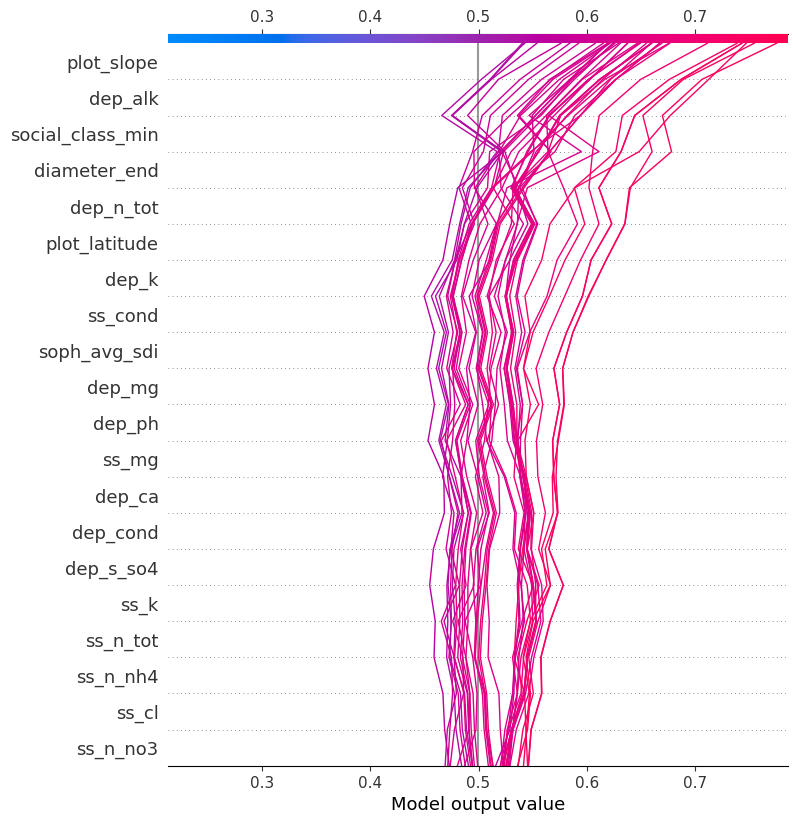

Decision plot for beech fold 1 with R2=0.542


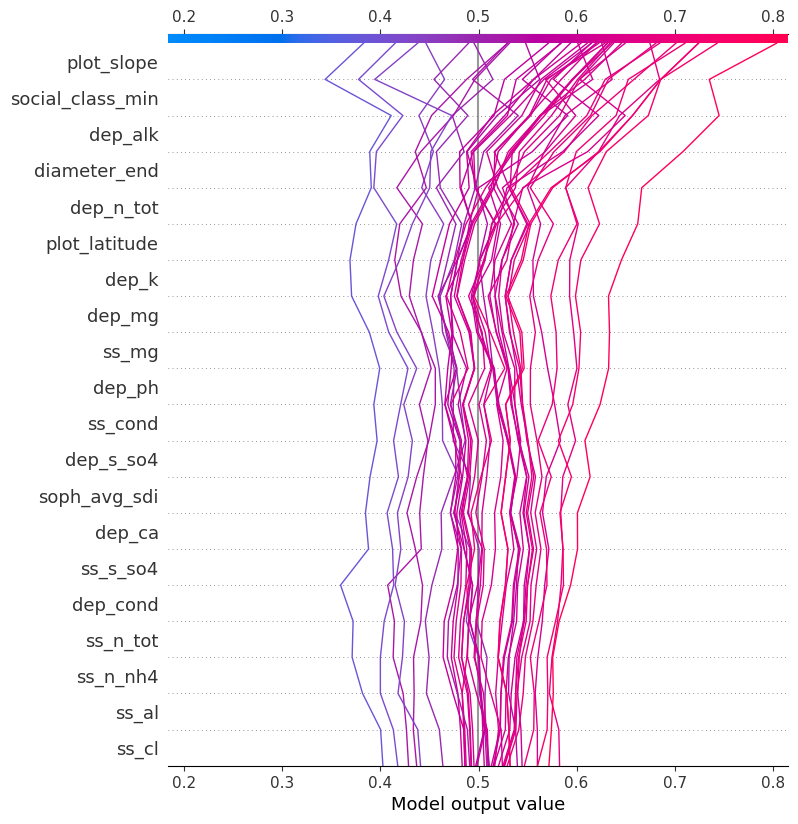

Results for spruce
 - 132 plot-period pairs
 - R2: 0.089 ± 0.185

Results for pine
 - 56 plot-period pairs
 - R2: 0.029 ± 0.168

Results for beech
 - 47 plot-period pairs
 - R2: 0.203 ± 0.270

Results for oak
 - 4 plot-period pairs
 - R2: 0.234 ± 0.148



/var/folders/8w/bgtq_bb95_bgd7nxmt9xj04h0000gn/T/ipykernel_64797/2404336199.py:28: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()
/var/folders/8w/bgtq_bb95_bgd7nxmt9xj04h0000gn/T/ipykernel_64797/2404336199.py:28: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()
/var/folders/8w/bgtq_bb95_bgd7nxmt9xj04h0000gn/T/ipykernel_64797/2404336199.py:28: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()
/var/folders/8w/bgtq_bb95_bgd7nxmt9xj04h0000gn/T/ipykernel_64797/2404336199.py:28: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()
/var/folders/8w/bgtq_bb95_bgd7nxmt9xj04h0000gn/T/ipykernel_64797/2404336199.py:28: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()
/var/folders/8w/bgtq_bb95_bgd7nxmt9xj04h0000gn/T/ipykernel_64797/2404336199.py:28: DeprecationWarning: `GroupBy.count` is dep

In [6]:
min_samples = 25
max_plots = 3

scores = {}
for species, results in all_results.items():
    num_plotted = 0

    scores[species] = []
    for fold in range(5):
        # Get the results for the current fold
        _, y_true, y_pred = results.get_data(fold, "test")
        indices = results.get_indices(fold, "test")

        # Add a unique identifier for the period
        metadata = (
            results.metadata.with_columns(
                pl.concat_str(pl.col("period_start"), pl.col("period_end"))
                .hash()
                .alias("period_id")
            )
            .with_row_index()
            .filter(pl.col("index").is_in(indices))
        )

        # Compute the R2 score for every unique (plot_id, period_id) pair with at least min_samples samples
        plot_period_pairs = (
            metadata.group_by("plot_id", "period_id")
            .count()
            .filter(pl.col("count") > min_samples)
        )

        for plot_id, period_id in (
            plot_period_pairs.select("plot_id", "period_id").unique().iter_rows()
        ):
            filter_expr = (metadata["plot_id"] == plot_id) & (
                metadata["period_id"] == period_id
            )

            r2 = r2_score(
                y_true.filter(filter_expr),
                y_pred.filter(filter_expr),
            )

            scores[species].append(r2)

            if num_plotted < max_plots and r2 > 0.5:
                print(f"Decision plot for {species} fold {fold} with R2={r2:.3f}")

                # Get the indices of the current plot-period pair
                plot_period_indices = filter_expr.arg_true().to_numpy()

                # Plot the decision plot
                shap.decision_plot(
                    results.explainers[fold].expected_value,
                    results.shap_values[fold][plot_period_indices].values,
                    feature_names=results.features,
                )

                num_plotted += 1

    scores[species] = pl.Series(species, scores[species])


for species, r2_scores in scores.items():
    print(f"Results for {species}")
    print(f" - {r2_scores.len()} plot-period pairs")
    print(f" - R2: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
    print()

## Feature importance by species

Here we show how feature importance varies by species.

Text(59.61133680555555, 0.5, 'Feature')

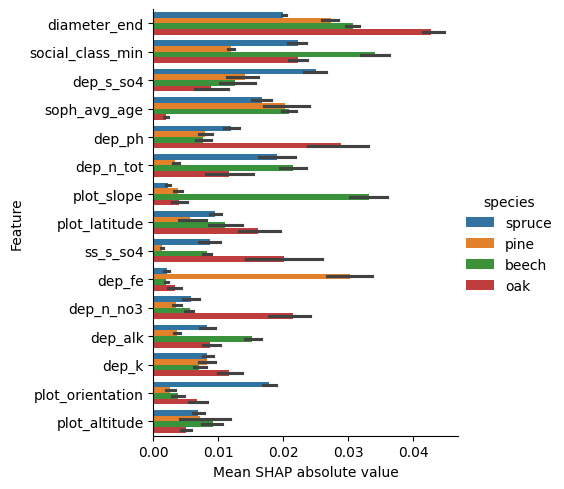

In [7]:
features = results.X.columns
top_n = 15

feature_importances = (
    pl.from_dicts(
        [
            {
                "species": species,
                "fold": fold,
                **dict(
                    zip(
                        features,
                        np.absolute(results.shap_values[fold].values).mean(axis=0),
                    )
                ),
            }
            for species, results in all_results.items()
            for fold in range(5)
        ]
    )
    .unpivot(
        on=pl.selectors.exclude("species", "fold"),  # type: ignore
        index=["species", "fold"],
        variable_name="feature",
        value_name="shap",
    )
    .with_columns(pl.col("shap").mean().over("feature").alias("importance"))
)

# Define order of features
feature_order = (
    feature_importances.group_by("feature")
    .agg(pl.col("importance").mean().alias("importance"))
    .sort("importance", descending=True)["feature"]
    .to_list()
)

sns.catplot(
    feature_importances,
    x="shap",
    y="feature",
    hue="species",
    kind="bar",
    order=feature_order[:top_n],
)
plt.xlabel("Mean SHAP absolute value")
plt.ylabel("Feature")

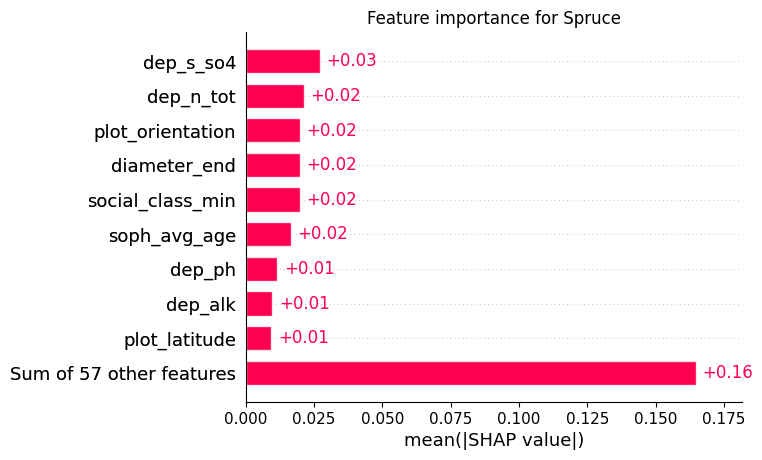

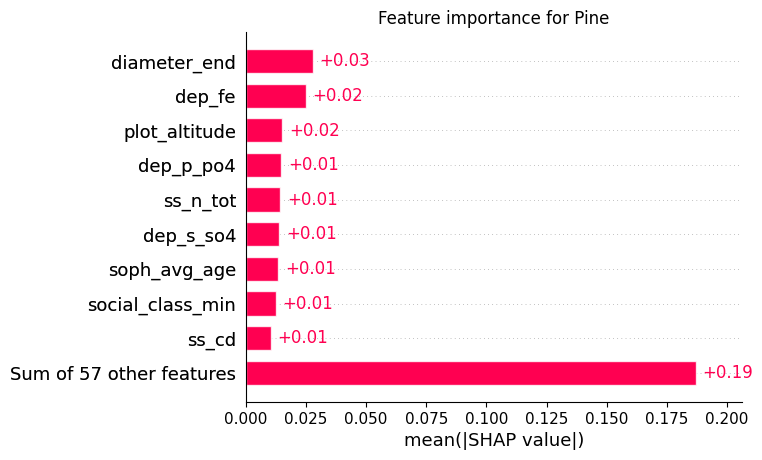

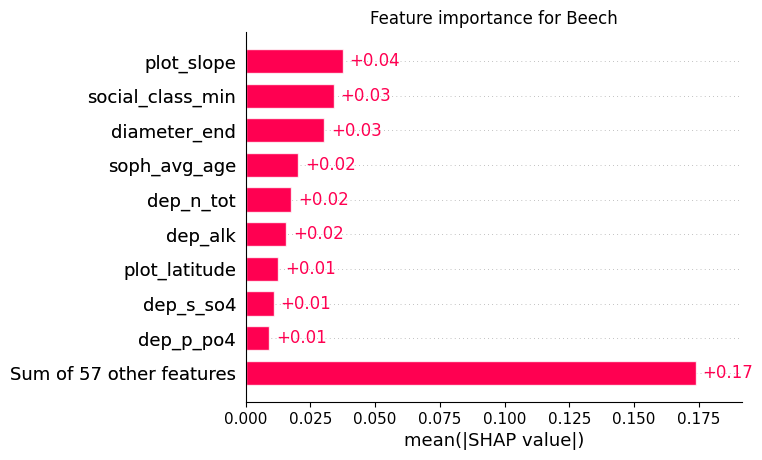

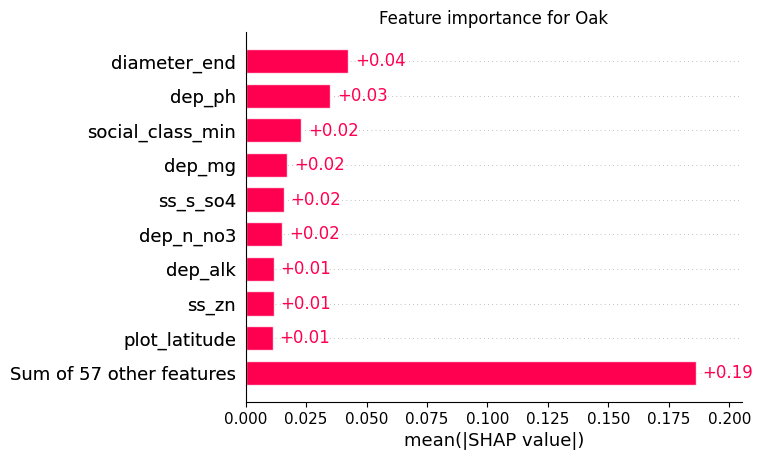

In [8]:
# Plot the top N features by species
for species, results in all_results.items():
    plt.figure()
    ax = shap.plots.bar(
        results.shap_values[4],
        max_display=10,
        ax=plt.gca(),
        show=False,
    )
    ax.set_title(f"Feature importance for {species.capitalize()}")

ColumnNotFoundError: "defoliation_mean_pred" not found

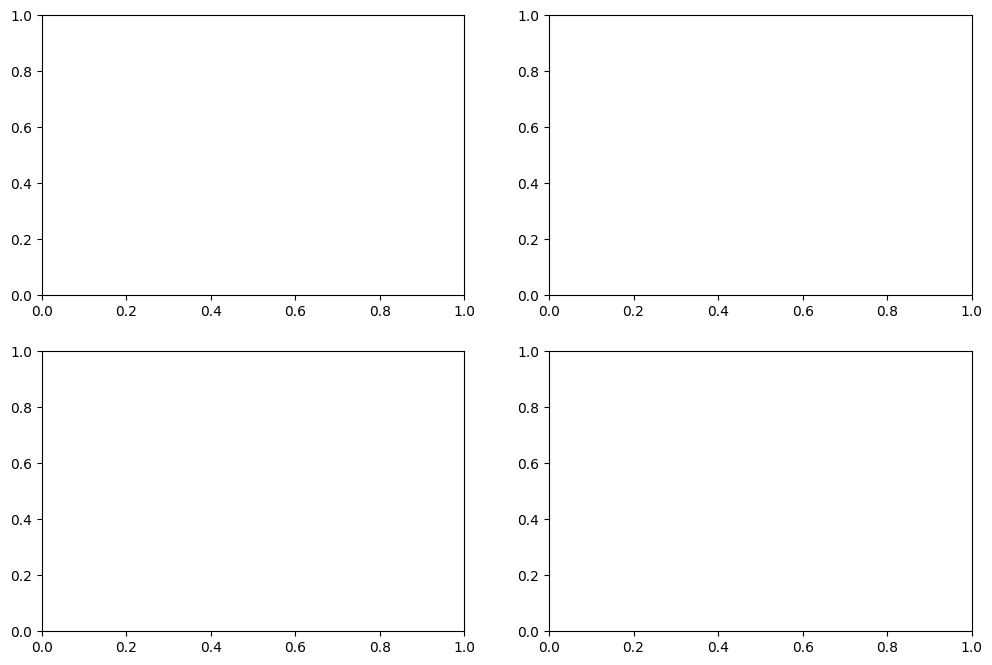

In [9]:
from scipy.optimize import curve_fit

feature = "defoliation_mean_pred"
interacting = "defoliation_mean_pred"
fit_curve = False
fold = 1

# One plot per species (4 in total)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Set global xlim and ylim based on the data
xlim = (
    min(
        cast(float, results.X[results.get_indices(fold, "all"), feature].min())
        for results in all_results.values()
    ),
    max(
        cast(float, results.X[results.get_indices(fold, "all"), feature].max())
        for results in all_results.values()
    ),
)

ylim = (
    min(
        cast(float, results.shap_values[fold][:, feature].values.min())
        for results in all_results.values()
    ),
    max(
        cast(float, results.shap_values[fold][:, feature].values.max())
        for results in all_results.values()
    ),
)


for species, ax in zip(all_species, axes.flatten()):
    results = all_results[species]

    # Get the SHAP values for the selected feature
    shapley_values = cast(np.ndarray, results.shap_values[fold][:, feature].values)
    feature_values = results.X[results.get_indices(fold, "all"), feature].to_numpy()
    growth_values = results.y_true[results.get_indices(fold, "all")].to_numpy()

    # Order dataset by feature values
    order_idx = np.argsort(feature_values)
    feature_values = feature_values[order_idx]
    shapley_values = shapley_values[order_idx]
    growth_values = growth_values[order_idx]

    # ax.scatter(
    #     # Add a bit of noise to the x-axis to avoid overlapping points
    #     feature_values + np.random.normal(0, 0.5, len(feature_values)),
    #     shapley_values,
    #     s=10,
    #     alpha=0.4,
    # )

    shap.plots.scatter(
        results.shap_values[fold][:, feature],
        color=results.shap_values[fold][:, interacting].values,
        alpha=0.4,
        ax=ax,
        show=False,
    )

    # Draw the line that indicates no effect
    ax.axhline(0, color="grey", linestyle="--")
    ax.text(xlim[1], ylim[1] / 20, "No effect", color="grey", ha="right")

    if fit_curve:
        # Fit a power law with vertical offset
        def func(x, a, b, c):
            return a * x**b + c

        # Get the SHAP values for the selected feature
        popt, _ = curve_fit(func, feature_values, shapley_values)

        # Plot the curve
        x = np.linspace(feature_values.min(), feature_values.max(), 100)
        ax.plot(
            x,
            func(x, *popt),
            color="red",
            label=f"y = {popt[0]:.2e} x^{popt[1]:.2f} + {popt[2]:.2f}",
        )

    ax.set_title(species.capitalize())
    ax.set_xlabel(feature)
    ax.set_ylabel("SHAP value")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend()

if fit_curve:
    fig.suptitle(f"Dependence plots for {feature} with power law fit (fold {fold})")
else:
    fig.suptitle(f"Dependence plots for {feature} (fold {fold})")

plt.tight_layout()

# Species-specific plots

Hereafter we investigate a specific species and feature.

In [ ]:
species: Species = "beech"
results = all_results[species]

In [ ]:
feature = "dep_n_tot"
interacting = "plot_orientation"

# Construct a DataFrame of the interaction values
feature_idx = results.X.columns.index(feature)

ax = shap.plots.scatter(
    results.shap_values[fold][:, feature],
    color=results.shap_values[fold][:, interacting],
    alpha=0.6,
)

In [ ]:
from explain import plot_ceteris_paribus_profile

fold = 0

X, _, y_pred = results.get_data(fold, "test")

# Plot 4 profiles for the selected feature
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

y_vec = y_pred.to_numpy()

for i, ax in enumerate(axes.flat):
    if i == 0:
        # Take 5 growth rates in the 5th percentile
        low, high = np.min(y_vec), np.percentile(y_vec, 5)
    elif i == 1:
        # Take 5 growth rates in the [20, 30] percentile
        low, high = (
            np.percentile(y_vec, 20),
            np.percentile(y_vec, 35),
        )
    elif i == 2:
        # Take 5 growth rates in the [70, 80] percentile
        low, high = (
            np.percentile(y_vec, 70),
            np.percentile(y_vec, 80),
        )
    else:
        # Take 5 growth rates in the 95th percentile
        low, high = np.percentile(y_vec, 95), np.max(y_vec)

    plot_period_indices = np.random.choice(
        np.argwhere((y_vec >= low) & (y_vec < high)).flatten(),
        5,
    )
    title = f"Growth rates between [{low:.2f}, {high:.2f}]"

    for idx in plot_period_indices:
        feature_range, y_pred = plot_ceteris_paribus_profile(
            results.estimators[fold], X, idx, feature, ax=ax
        )
    ax.set_title(title)
    # ax.set_ylim([0.2, 0.8])

plt.tight_layout()

## Explain a subset of the data

We explain only data within:

- A given climatic area (`boreal`, `high_altitude`, `dry`).

In [ ]:
from data import load_data

split = "all"
min_samples = 250

# Load the data and the corresponding results
data = load_data(species)
results = all_results[species]

# Map each category to a Polar expression to retrieve the corresponding indices
category_idx_expr = {
    "boreal": pl.arg_where(pl.col("plot_latitude") >= 500000),
    "temperate": pl.arg_where(pl.col("plot_latitude") < 500000),
    "high_altitude": pl.arg_where(pl.col("plot_altitude") >= 1000),
    "low_altitude": pl.arg_where(pl.col("plot_altitude") <= 200),
    "hot": pl.arg_where(pl.col("soph_avg_temp") >= 13.5),
    "cold": pl.arg_where(pl.col("soph_avg_temp") <= 10),
    "flat": pl.arg_where(pl.col("plot_slope") <= 5),
    "hilly": pl.arg_where(pl.col("plot_slope") > 20),
    "dry": pl.arg_where(pl.col("soph_avg_precip") < 400),
    "humid": pl.arg_where(pl.col("soph_avg_precip") > 800),
}

shap_values = []
categories = []

for label, filter in category_idx_expr.items():
    indices = data.select(filter).to_series().to_numpy()

    if len(indices) < min_samples:
        print(f"Not enough samples for {label}")
        continue

    features = results.X[indices, :].to_pandas()
    shap_np = cast(np.ndarray, results.shap_values[fold][indices].values)

    for idx in range(shap_np.shape[0]):
        shap_values.append(shap_np[idx, :])

    categories.extend([label] * shap_np.shape[0])

# Plot the feature importances by category
df = (
    pl.from_numpy(np.absolute(np.stack(shap_values, axis=1).T), schema=results.features)
    .with_columns(pl.Series("condition", categories))
    .unpivot(
        on=pl.selectors.exclude("condition"),
        variable_name="feature",
        value_name="importance",
        index=["condition"],
    )
    .filter(pl.col("condition").is_in(["boreal", "high_altitude", "dry", "hot"]))
)

sns.catplot(
    df,
    x="importance",
    y="feature",
    hue="condition",
    kind="bar",
    order=feature_order[:10],
)
plt.xlabel("Feature importance (mean absolute SHAP value)")
plt.ylabel("Feature")
plt.title(f"Feature importances by condition (species = {species.capitalize()})")

In [ ]:
# Plot dependence plots for the selected feature by category
feature = "defoliation_max"
interacting = "defoliation_max"

# 2x2 grid for the 4 categories
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# Define x- and y-axis limits based on global min and max values
x_min = data[feature].min()
x_max = data[feature].max()
y_min = np.min(results.shap_values[fold][:, feature].values)
y_max = np.max(results.shap_values[fold][:, feature].values)

# Background points (temperate)
background_indices = data.select(category_idx_expr["temperate"]).to_series().to_numpy()

for idx, conditions in enumerate(["boreal", "high_altitude", "dry", "hot"]):
    indices = data.select(category_idx_expr[conditions]).to_series().to_numpy()

    if len(indices) < 25:
        print(f"Not enough samples for {conditions}")
        continue

    ax = axes[idx]

    shap.plots.scatter(
        results.shap_values[fold][background_indices, feature],
        ax=ax,
        alpha=0.05,
        show=False,
        hist=False,
        color="grey",
    )

    shap.plots.scatter(
        results.shap_values[fold][indices, feature],
        ax=ax,
        alpha=0.4,
        show=False,
        # Iterate on tab10 colors
        color=plt.cm.tab10(idx),
    )

    # Draw the line that indicates no effect with a label
    ax.axhline(0, color="grey", linestyle="--")
    ax.text(x_max, y_max / 20, "No effect", color="grey", ha="right")

    ax.set_title(conditions.capitalize().replace("_", " "))
    ax.set_xlabel(feature)
    ax.set_ylabel("SHAP values")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

plt.tight_layout()

In [ ]:
# Visualize Shapley values using t-SNE
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Build a dataframe of shapley values across all species
df_shap = []
species_col = []
plot_id_col = []
for species, results in all_results.items():
    for fold in range(5):
        df_shap.append(results.shap_values[fold].values)
        species_col.extend([species] * len(df_shap[-1]))
        plot_id_col.extend(results.metadata["plot_id"].to_numpy())

# Build a dataframe of SHAP values, downsampled to 20,000 samples
df_shap = (
    pl.from_numpy(np.concatenate(df_shap, axis=0), schema=results.features)
    .with_columns(pl.Series("species", species_col), pl.Series("plot_id", plot_id_col))
    .select("species", "plot_id", pl.exclude("species", "plot_id"))
).sample(n=20000)

# Standardize the data
scaler = StandardScaler()
X_shap = np.nan_to_num(
    scaler.fit_transform(df_shap.select(pl.exclude("species")).to_numpy())
)

# Train the t-SNE model
tsne = TSNE(n_components=2, perplexity=100, early_exaggeration=20)
X_tsne = tsne.fit_transform(X_shap)

In [ ]:
# Use seaborn to generate a scatter plot of the t-SNE results

ax = sns.scatterplot(
    data=df_shap.with_columns(
        pl.Series("tsne_x", X_tsne[:, 0]), pl.Series("tsne_y", X_tsne[:, 1])
    ).to_pandas(),
    x="tsne_x",
    y="tsne_y",
    hue="species",
    alpha=0.5,
    palette="muted",
    s=5,
    legend="brief",
)

ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")

plt.tight_layout()

In [ ]:
# Produce a zoom in a specific region
x_bounds = [0, 40]
y_bounds = [-40, 0]

# Create 2 subplots of the zoomed region: one for the species and one for the plot_id

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for ax, col in zip(axes, ["species", "plot_id"]):
    sns.scatterplot(
        data=df_shap.with_columns(
            pl.Series("tsne_x", X_tsne[:, 0]), pl.Series("tsne_y", X_tsne[:, 1])
        ).to_pandas(),
        x="tsne_x",
        y="tsne_y",
        hue=col,
        alpha=0.9,
        palette="muted" if col == "species" else "dark",
        legend=False,
        s=10,
        ax=ax,
    )

    ax.set_xlim(x_bounds)
    ax.set_ylim(y_bounds)

    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")

    plt.tight_layout()

## Feature interactions

We can compute the Shapley interactions using `get_shap_interactions`, which returns a tensor `(# samples, # features, # features)`, where each slice along the first axis is a symmetric matrix of interaction values, whose each row sums to the Shapley value for this feature. The diagonal entries represent the "main effect" attributed to that feature, whereas other entires represent the first-order interactions with every other feature.

In [ ]:
from explain import plot_interaction_matrix

top_n_features = (
    feature_importances.select("feature", "importance")
    .unique()
    .sort("importance", descending=True)
    .head(20)["feature"]
    .to_list()
)

# Loop over the species
for species in all_species:
    results = all_results[species]

    # Plot the mean absolute interaction values for the selected feature as a heatmap
    plt.figure(figsize=(10, 8))
    ax = plt.gca()

    interactions = plot_interaction_matrix(results, top_n=top_n_features, ax=ax)
    plt.tight_layout()
    plt.title(f"Interactions for {species}")

    plt.savefig(f"figures/{species}-interactions-mean.png")